# Step 1. 구글 연동 및 필요 라이브러리 불러들이기

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.21.6
2.8.2


In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Step 2. 데이터 불러오기

이번 프로젝트에서는 'cityscapes.zip'라는 이름의 압축 파일 형태의 데이터셋을 이용해 Pix2Pix를 학습시켜 보고자 한다.  
'cityscapes.zip'라는 이름의 압축 파일을 다운로드 한 후 압축을 풀어준다.  
1000개의 학습용 이미지 및 5개의 평가 이미지가 포함되어 있는 것을 확인한다.

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없을 것이다.
아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같다.

In [37]:
import os

data_path = '/content/drive/MyDrive/AIFFEL/DATASET/Ex16/train/'
print("훈련데이터의 개수 :", len(os.listdir(data_path)))

훈련데이터의 개수 : 1000


훈련 데이터의 개수는 1000개라고 정상적으로 뜨는 거 확인했고, 이미지 형태를 확인해 보면~~

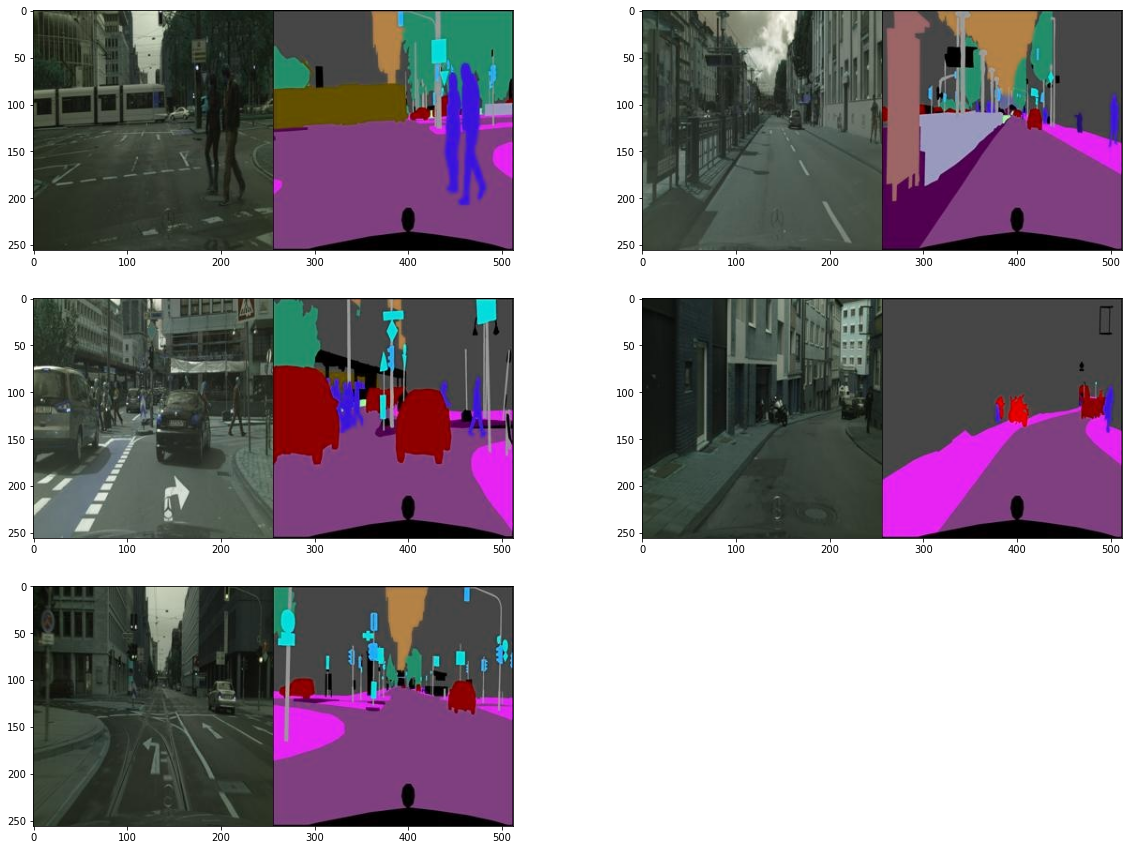

In [72]:
plt.figure(figsize=(20,15))
for i in range(1,6):
  f = data_path + os.listdir(data_path)[np.random.randint(1000)]
  img = cv2.imread(f, cv2.IMREAD_COLOR)  # cv2.IMREAD_COLOR는 이미지파일을 컬러로 읽어드립니다.
  plt.subplot(3,2,i)
  plt.imshow(img)

이런 식으로 왼쪽에 실제 이미지와 오른쪽의 채색 전의 이미지(segmentation image)로 구성이 되어 있는 사진 6장을 임의로 불러온 것을 확인할 수 있고, 이번에는 이미지 하나를 열어 그 크기를 확인해 본다.

In [73]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


이제 (256, 256, 3) 크기의 2개 이미지로 양분을 하여 사용을 할 수 있도록 다음과 같은 함수를 지정해 준다.

In [74]:
# pixel 값을 -1~1로 정규화 해주는 함수
def normalize(x):
  x = tf.cast(x, tf.float32)
  return (x/127.5) - 1

# pixel 값을 다시 원래대로 되돌리는 함수
def denormalize(x):
  x = (x+1) * 127.5
  x = x.numpy()
  return x.astype(np.uint8)


# 이미지 불러오는 함수
def load_img(img_path):
  image = tf.io.read_file(img_path)
  image = tf.io.decode_jpeg(image)

  w = tf.shape(image)[1] // 2
  real_img = image[:, :w, :]
  input_img = image[:, w:, :]

  real_img = tf.cast(real_img, tf.float32)
  input_img = tf.cast(input_img, tf.float32)

  return normalize(input_img), normalize(real_img)

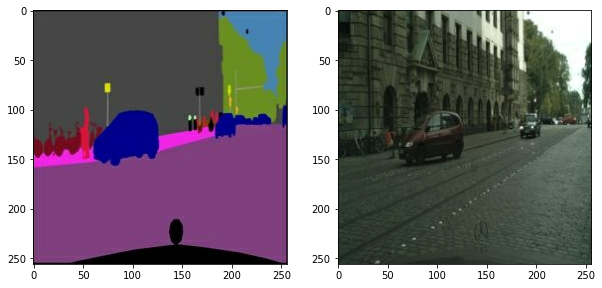

In [75]:
input_img, real_img = load_img(data_path + '300.jpg')

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_img))
plt.subplot(1,2,2); plt.imshow(denormalize(real_img))

# Step 3. Augmentation

학습에 사용할 수 있는 데이터 수는 1000개이다. 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 Augmentation 방법을 적용한다.

In [76]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용.
def apply_augmentation(input_img, real_img):
  stacked = tf.concat([input_img, real_img], axis=-1)

  _pad = tf.constant([[30,30],[30,30],[0,0]])
  if tf.random.uniform(()) < .5:
    padded = tf.pad(stacked, _pad, 'REFLECT')
  else:
    padded = tf.pad(stacked, _pad, 'CONSTANT', constant_values=1.)

  out = image.random_crop(padded, size=[256,256,6])

  out = image.random_flip_left_right(out)
  out = image.random_flip_up_down(out)
  out = image.random_brightness(out, 0.2) # augmentation 추가
  out = image.random_contrast(out, 0.2, 0.5)


  if tf.random.uniform(()) < .5:
    degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
    out = image.rot90(out, k=degree)
  
  return out[...,:3], out[...,3:]

1. 두 이미지가 채널 축으로 연결된다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 된다.  

2. 1번의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용시킨다. (tf.pad)

3. 2번의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라낸다. (tf.image.random_crop)

4. 3번의 결과를 50% 확률로 가로로 뒤집는다. (tf.image.random_flip_left_right)

5. 4번의 결과를 50% 확률로 세로로 뒤집는다. (tf.image.random_flip_up_down)

6. 5의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

위와 같이 구성한 함수를 데이터에 적용해 시각화를 해본다.

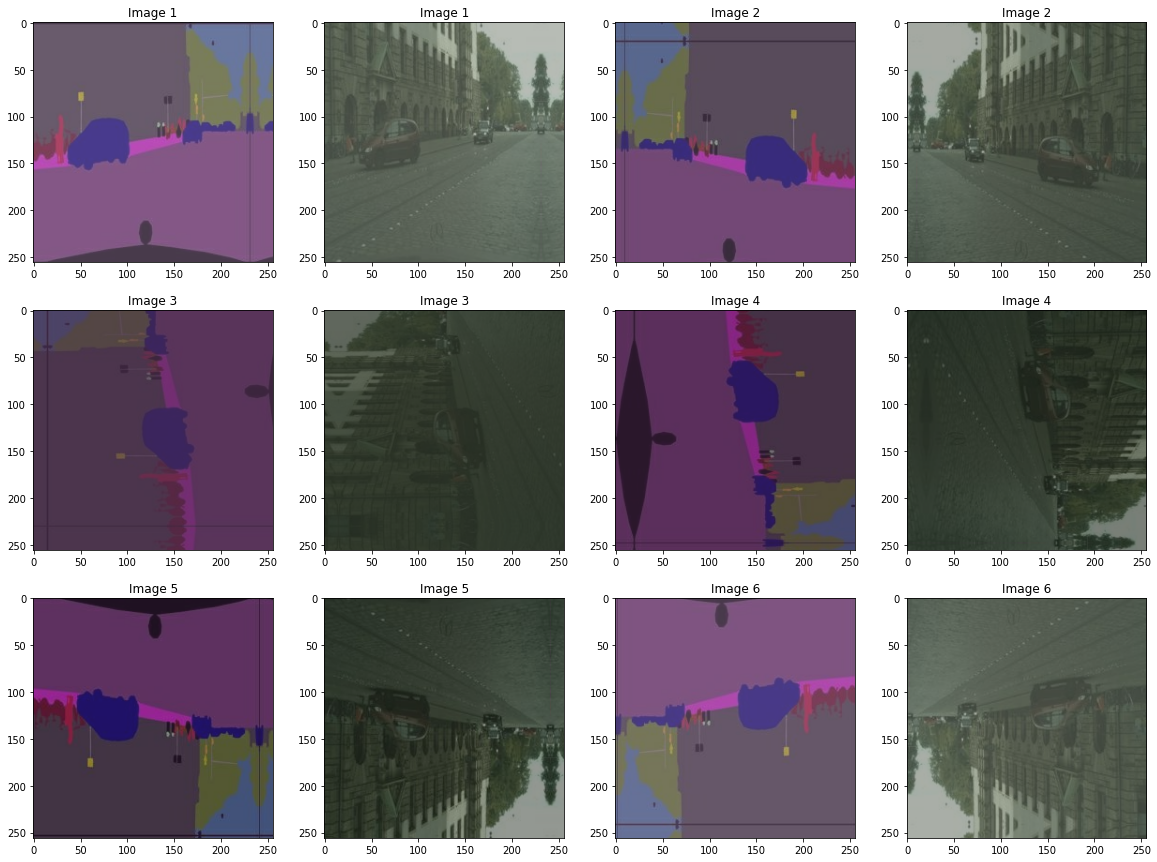

In [77]:
plt.figure(figsize=(20,15))
img_n = 1
for i in range(1, 13, 2):
  augmented_input, augmented_real = apply_augmentation(input_img, real_img)

  plt.subplot(3, 4, i)
  plt.imshow(denormalize(augmented_input))
  plt.title(f'Image {img_n}')
  plt.subplot(3, 4, i+1)
  plt.imshow(denormalize(augmented_real))
  plt.title(f'Image {img_n}')
  img_n += 1

매우 다양한 이미지가 생성되었다. 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있다.

마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해 보자.

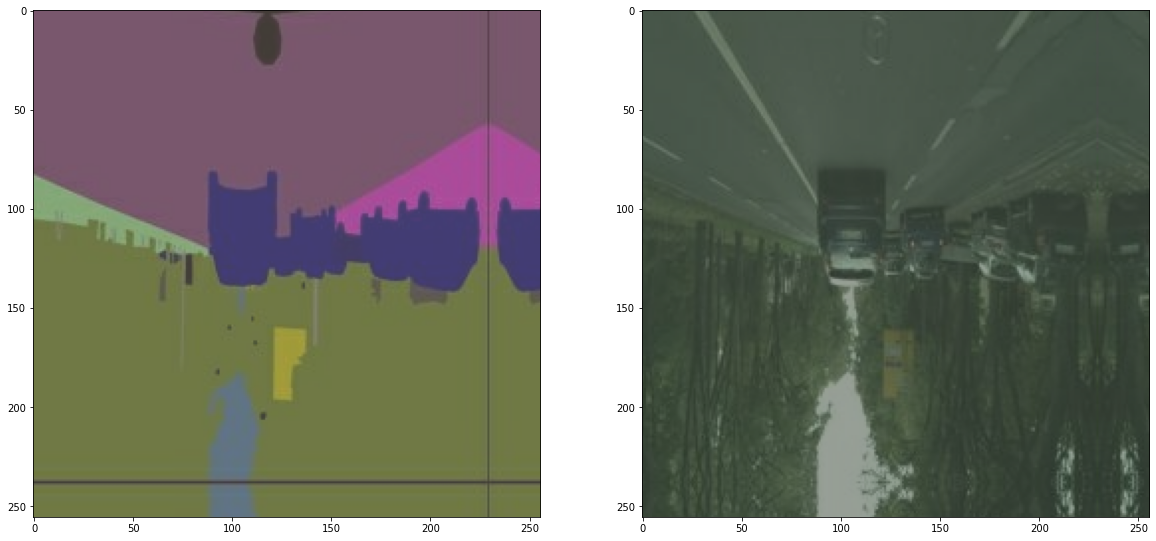

In [78]:
from tensorflow import data

def get_train(img_path):
  input, real = load_img(img_path)
  input, real = apply_augmentation(input, real)
  return input, real

train_img = data.Dataset.list_files(data_path + '*.jpg')
train_img = train_img.map(get_train).shuffle(100).batch(4)

sample = train_img.take(1)
sample = list(sample.as_numpy_iterator())
input, real = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(input[0].astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow(real[0].astype(np.uint8))

# Step4. Generator구성하기(U-Net)

Pix2Pix의 Generator 구조는 Encoder-Decoder와 U-Net 두가지가 있다. 하지만 단순한 Encoder-Decoder구조에 비해 Encoder와 Decoder사이를 skip connection으로 연결한 U-Net구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보인다.

더 좋은 결과를 기대하기위해 U-Net구조로 Generator를 구성해 볼 것이다.

위 정보들을 토대로 여러분의 머릿속에 희미하게 그려진 Generator의 Encoder 부분을 구현할 것이다.
먼저  "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었다.

In [79]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
  def __init__(self, n_filters, use_bn=True):
    super(EncodeBlock, self).__init__()
    self.use_bn = use_bn
    self.conv = layers.Conv2D(n_filters, 4, 2, 'same', use_bias=False)
    self.batchnorm = layers.BatchNormalization()
    self.lrelu = layers.LeakyReLU(0.2)

  def call(self, x):
    x = self.conv(x)
    if self.use_bn:
      x = self.batchnorm(x)
    return self.lrelu(x)

`__init__()` 메서드에서 `n_filters`, `use_bn`를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정할 수 있다.
이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했다.
Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러 번 가져다 사용하면 아래와 같이 쉽게 Encoder를 구성할 수 있다.

In [80]:
class Encoder(layers.Layer):
  def __init__(self):
    super(Encoder, self).__init__()
    filters = [64, 128, 256, 512, 512, 512, 512, 512]

    self.blocks=[]
    for i, f in enumerate(filters):
      if i == 0:
        self.blocks.append(EncodeBlock(f, use_bn=False))
      else:
        self.blocks.append(EncodeBlock(f))
  
  def call(self, x):
    for block in self.blocks:
      x = block(x)
    return x
  
  def get_summary(self, input_shape=(256,256,3)):
    inputs = Input(input_shape)
    return Model(inputs, self.call(inputs)).summary()

각 블록을 거치면서 사용할 필터의 개수를 filters라는 리스트에 지정해 두었으며, blocks이라는 리스트에는 사용할 블록들을 정의해 넣어두고, call() 메서드에서 차례대로 블록들을 통과한다. 즉, Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않는다.
get_summary는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들어 놓았다. 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴보자. 만들어 놓은 get_summary 메서드를 바로 불러오시면 된다.

In [81]:
Encoder().get_summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 encode_block_64 (EncodeBloc  (None, 128, 128, 64)     3072      
 k)                                                              
                                                                 
 encode_block_65 (EncodeBloc  (None, 64, 64, 128)      131584    
 k)                                                              
                                                                 
 encode_block_66 (EncodeBloc  (None, 32, 32, 256)      525312    
 k)                                                              
                                                                 
 encode_block_67 (EncodeBloc  (None, 16, 16, 512)      2099200   
 k)                                                       

블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인할 수 있다.

이번엔 Decoder를 구현해 볼 것이다. Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러 번 반복하여 아래와 같이 Decoder를 만들어 보자.

In [82]:
class DecoderBlock(layers.Layer):
  def __init__(self, f, dropout=True):
    super(DecoderBlock, self).__init__()
    self.dropout = dropout
    self.Transconv = layers.Conv2DTranspose(f, 4, 2, 'same', use_bias=False)
    self.batchnorm = layers.BatchNormalization()
    self.relu = layers.ReLU()

  def call(self, x):
    x = self.Transconv(x)
    x = self.batchnorm(x)
    if self.dropout:
      x = layers.Dropout(.5)(x)
    return self.relu(x)

class Decoder(layers.Layer):
  def __init__(self):
    super(Decoder, self).__init__()
    filters = [512, 512, 512, 512, 256, 128, 64]

    self.blocks= []
    for i, f in enumerate(filters):
      if i < 3:
        self.blocks.append(DecoderBlock(f))
      else:
        self.blocks.append(DecoderBlock(f, dropout=False))
      
    self.blocks.append(layers.Conv2DTranspose(3, 4, 2, 'same', use_bias=False))
  
  def call(self, x):
    for block in self.blocks:
      x = block(x)
    return x
  
  def get_summary(self, input_shape=(1,1,512)):
    inputs = Input(input_shape)
    return Model(inputs, self.call(inputs)).summary()

처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있다.
마찬가지로 (1,1,512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해 보자.

In [83]:
Decoder().get_summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1, 1, 512)]       0         
                                                                 
 decoder_block (DecoderBlock  (None, 2, 2, 512)        4196352   
 )                                                               
                                                                 
 decoder_block_1 (DecoderBlo  (None, 4, 4, 512)        4196352   
 ck)                                                             
                                                                 
 decoder_block_2 (DecoderBlo  (None, 8, 8, 512)        4196352   
 ck)                                                             
                                                                 
 decoder_block_3 (DecoderBlo  (None, 16, 16, 512)      4196352   
 ck)                                                      

(width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력되었다.

위에서 구성한 Encoder와 Decoder를 연결시키면 Encoder에서 (256,256,3) 입력이 (1,1,512)로 변환되고, Decoder를 통과해 다시 원래 입력 크기와 같은 (256,256,3)의 결과를 얻을 수 있을 것이다. 스케치를 입력으로 이런 연산 과정을 통해 채색된 이미지 출력을 얻을 수 있다.
아래 코드와 같이 tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성해 보자.

In [84]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 encoder_5 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_5 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


Generator를 잘 작동시키기 위해서는 약 4000만 개의 파라미터를 잘 학습시켜야 한다!!!

정의된 블록들을 이용해 한 번에 **U-Net Generator**를 정의해 보겠다. 아래 모델의 `__init__()` 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, `call()`에서 forward propagation 한다. 이전 구현에는 없었던 skip connection이 `call()` 내부에서 어떻게 구현되었는지 잘 확인해 보자.

In [85]:
class UNetGenerator(Model):
  def __init__(self):
    super(UNetGenerator, self).__init__()
    encoder_filters = [64, 128, 256, 512, 512, 512, 512, 512]
    decoder_filters = [512, 512, 512, 512, 256, 128, 64]

    self.encode_blocks = []
    for i, f in enumerate(encoder_filters):
      if i == 0:
        self.encode_blocks.append(EncodeBlock(f, use_bn=False))
      else:
        self.encode_blocks.append(EncodeBlock(f))
    
    self.decode_blocks = []
    for i, f in enumerate(decoder_filters):
      if i < 3:
        self.decode_blocks.append(DecoderBlock(f))
      else:
        self.decode_blocks.append(DecoderBlock(f, dropout=False))
    
    self.last_conv = layers.Conv2DTranspose(3, 4, 2, 'same', use_bias=False)
  
  def call(self, x):
    features = []
    for block in self.encode_blocks:
      x = block(x)
      features.append(x)

    features = features[:-1]

    for block, feat in zip(self.decode_blocks, features[::-1]):
      x = block(x)
      x = layers.Concatenate()([x,feat])
    
    x = self.last_conv(x)
    return x
  
  def get_summary(self, input_shape=(256,256,3)):
    inputs = Input(input_shape)
    return Model(inputs, self.call(inputs)).summary()

In [86]:
UNetGenerator().get_summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_80 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_18[0][0]']               
                                )                                                                 
                                                                                                  
 encode_block_81 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_80[0][0]']        
                                                                                           

## Discriminator 구현하기

Generator만으로는 좋은 결과를 도출하기에 부족하다. 조금 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요하다.
이번 단계에서 Discriminator를 만들어 Pix2Pix 구조를 완성시킬 것이다.  
마찬가지로 Discriminator에 사용할 기본적인 블록부터 만들어 둔다.

In [88]:
class DiscBlock(layers.Layer):
  def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
    super(DiscBlock, self).__init__()
    self.custom_pad = custom_pad
    self.use_bn = use_bn
    self.act = act

    if custom_pad:
      self.padding = layers.ZeroPadding2D()
      self.conv = layers.Conv2D(n_filters, 4, stride, 'valid', use_bias=False) # padding='valid' -> no padding
    else:
      self.conv = layers.Conv2D(n_filters, 4, stride, 'same', use_bias=False) # padding='same' -> zeropadding
    
    self.batchnorm = layers.BatchNormalization()
    self.lrelu = layers.LeakyReLU(0.2) if act else None

  def call(self, x):
    if self.custom_pad:
      x = self.padding(x)
      x = self.conv(x)
    else:
      x = self.conv(x)

    if self.use_bn:
      x = self.batchnorm(x)
    
    if self.act:
      x = self.lrelu(x)
    return x

* 패딩 레이어 통과 layers.ZeroPadding2D() : width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어난다.  
출력 : (130,130,32)

* Convolution 레이어 통과 layers.Conv2D(64,4,1,"valid") : 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어듭니다. 이는 OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1 의 식으로 계산할 수 있습니다. 채널 수는 사용한 필터 개수와 같습니다.  
출력 : (127,127,64)

* BatchNormalization 레이어 통과 layers.BatchNormalization() → (127,127,64)
* LeakyReLU 활성화 레이어 통과 layers.LeakyReLU(0.2) → (127,127,64)

* 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않는다.

In [89]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d_14 (ZeroPadd  (None, 130, 130, 32)     0         
 ing2D)                                                          
                                                                 
 conv2d_120 (Conv2D)         (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_185 (Ba  (None, 127, 127, 64)     256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_114 (LeakyReLU)  (None, 127, 127, 64)     0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainabl

Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 설명했다.
사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어 보자.

In [90]:
class Discriminator(Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.block1 = layers.Concatenate()
    self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
    self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
    self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
    self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
    self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
    self.sigmoid = layers.Activation('sigmoid')

    # filters = [64,128,256,512,1]
    # self.blocks = [layers.Concatenate()]
    # for i, f in enumerate(filters):
    #     self.blocks.append(DiscBlock(
    #         n_filters=f,
    #         strides=2 if i<3 else 1,
    #         custom_pad=False if i<3 else True,
    #         use_bn=False if i==0 and i==4 else True,
    #         act=True if i<4 else False
    #     ))    

  def call(self, x, y):
    out = self.block1([x,y])
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)
    out = self.block6(out)
    return self.sigmoid(out)

  def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
    x, y = Input(x_shape), Input(y_shape)
    return Model((x,y), self.call(x,y)).summary()

In [56]:
Discriminator().get_summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_14 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_17 (Concatenate)   (None, 256, 256, 6)  0           ['input_13[0][0]',               
                                                                  'input_14[0][0]']        

시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해 보겠다.

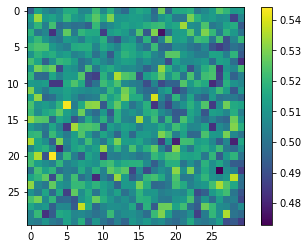

In [91]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

이전 PatchGAN에 대해 설명했던 것처럼, 위 (30,30) 크기를 갖는 결과 이미지의 각 픽셀 값은 원래 입력의 (70,70) 패치에 대한 분류 결과이다. 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있겠죠. 각각의 픽셀 값은 sigmoid 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해 내는 데 사용한다.

드디어 Pix2Pix를 구성하는 Generator와 Discriminator의 구현이 끝났다.
다음 단계에서 본격적인 모델 학습을 진행해 보자!

# Step 5. 생성자(Generator)와 판별자(Discriminator) 학습

In [92]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
  l1_loss = mae(real_output, fake_output)
  gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
  return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
  return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

* Generator의 손실 함수 (위 코드의 `get_gene_loss`)는 총 3개의 입력이 있습니다. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 `tf.ones_like()`를 사용합니다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(`fake_output`)와 실제 이미지(`real_output`) 사이의 MAE(Mean Absolute Error)를 계산한다.

* Discriminator의 손실 함수 (위 코드의 `get_disc_loss`)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값이다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 `real_disc`는 "1"로 채워진 벡터와 비교하고, `fake_disc`는 "0"으로 채워진 벡터와 비교한다.

In [93]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현할 수 있다.

In [94]:
@tf.function
def train_step(input_img, real_img):
  with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
    # Generator 예측
    fake_color = generator(input_img, training=True)
    # Discriminator 예측
    fake_disc = discriminator(input_img, fake_color, training=True)
    real_disc = discriminator(input_img, real_img, training=True)
    # Generator 손실 계산
    gene_loss, l1_loss = get_gene_loss(fake_color, real_img, fake_disc)
    gene_total_loss = gene_loss + ( 100 * l1_loss) ## <==== L1 손실 반영 λ=100
    # Discriminator 손실 계산
    disc_loss = get_disc_loss(fake_disc, real_disc)

  gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
  disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
  disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
  return gene_loss, l1_loss, disc_loss

In [95]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

# 그래프를 그리기 위해 loss들의 리스트를 만들고 결과 출력 마다 loss값을 추가해서 기록

g_loss_list = []
d_loss_list = []
l1_loss_list = []
for epoch in range(1, EPOCHS+1):
  for i, (input, real) in enumerate(train_img):
    g_loss, l1_loss, d_loss = train_step(input, real)
    # 100회 반복마다 손실을 출력
    if (i+1) % 100 == 0:
      print(f'EPOCH[{epoch}] - STEP[{i+1}] \n Generator_loss:{g_loss.numpy():.4f} \n L1_loss:{l1_loss.numpy():.4f} \n Discriminator_loss:{d_loss.numpy():.4f}', end='\n\n')

    g_loss_list.append(g_loss.numpy())
    d_loss_list.append(d_loss.numpy())
    l1_loss_list.append(l1_loss.numpy())

EPOCH[1] - STEP[100] 
 Generator_loss:1.0616 
 L1_loss:0.0987 
 Discriminator_loss:1.2361

EPOCH[1] - STEP[200] 
 Generator_loss:1.7592 
 L1_loss:0.1455 
 Discriminator_loss:1.2203

EPOCH[2] - STEP[100] 
 Generator_loss:1.4864 
 L1_loss:0.1052 
 Discriminator_loss:1.0409

EPOCH[2] - STEP[200] 
 Generator_loss:1.6087 
 L1_loss:0.0903 
 Discriminator_loss:0.5438

EPOCH[3] - STEP[100] 
 Generator_loss:0.3823 
 L1_loss:0.1156 
 Discriminator_loss:1.3896

EPOCH[3] - STEP[200] 
 Generator_loss:0.7446 
 L1_loss:0.1068 
 Discriminator_loss:2.2327

EPOCH[4] - STEP[100] 
 Generator_loss:0.9936 
 L1_loss:0.1058 
 Discriminator_loss:1.9129

EPOCH[4] - STEP[200] 
 Generator_loss:1.7787 
 L1_loss:0.0897 
 Discriminator_loss:1.4031

EPOCH[5] - STEP[100] 
 Generator_loss:0.7614 
 L1_loss:0.1096 
 Discriminator_loss:1.1784

EPOCH[5] - STEP[200] 
 Generator_loss:0.6882 
 L1_loss:0.0903 
 Discriminator_loss:1.3585

EPOCH[6] - STEP[100] 
 Generator_loss:0.4942 
 L1_loss:0.0904 
 Discriminator_loss:1.3308


# Step 6. 테스트

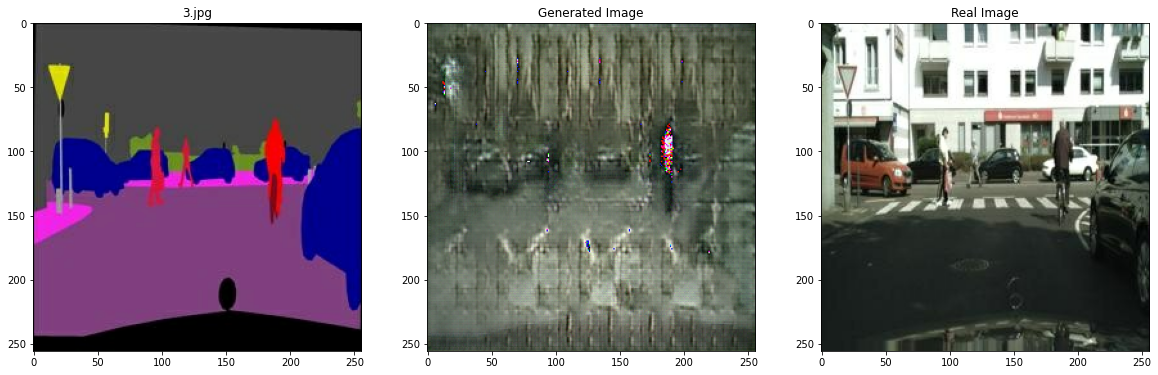

In [100]:
test_ind = 1
test_data_path = '/content/drive/MyDrive/AIFFEL/DATASET/Ex16/val/'
f = test_data_path + os.listdir(test_data_path)[test_ind]
input_img, real_img = load_img(f)

pred = generator(tf.expand_dims(input_img, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title(f'{os.listdir(test_data_path)[test_ind]}')
plt.imshow(denormalize(input_img))
plt.subplot(1,3,2)
plt.title('Generated Image')
plt.imshow(pred[0])
plt.subplot(1,3,3)
plt.title('Real Image')
plt.imshow(denormalize(real_img))
plt.savefig('/content/drive/MyDrive/AIFFEL/DATASET/Ex16/val/fourth_result.jpeg', format='jpeg')

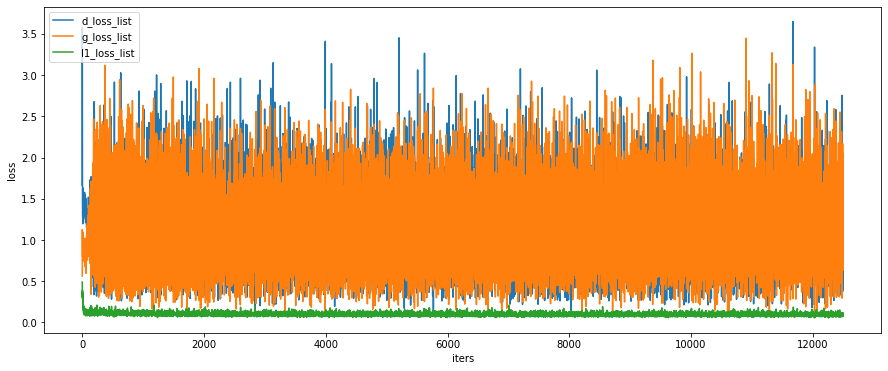

In [98]:
plt.figure(figsize=(15,6))
plt.plot(d_loss_list)
plt.plot(g_loss_list)
plt.plot(l1_loss_list)
plt.ylabel('loss')  
plt.xlabel('iters') 
plt.legend(['d_loss_list', 'g_loss_list', 'l1_loss_list'], loc='upper left')
plt.savefig('/content/drive/MyDrive/AIFFEL/DATASET/Ex16/val/fourth_result_loss.jpeg', format='jpeg')
plt.show()

# 회고

* 이번 실습에서는 segmentation 이미지를 넣으면 실제 이미지와 유사한 이미지를 출력해 보는 Pix2Pix를 이용해 봤다.

* 최종적으로는 50에포크를 돌려봤는데, 실제 이미지와 유사한 모습이 잘 보이지는 않는 거 같다. 시간 부족으로 100에포크, 200에포크 까지 시도를 못 해본것이 무척 아쉬웠다.